##**Predicting DNA N6-Methyladenine Sites in Rice Genome**

#**Dataset**

The first dataset is the 6mA-rice-Chen dataset (Chen et al., 2019), which was widely used by previous studies (Basith et al., 2019; Chen et al., 2019; Pian et al., 2019; Tahir et al., 2019). The **6mA-rice-Chen** dataset contains 880 positive samples and 880 negative samples. The second dataset we used is the **6mA-rice-Lv dataset** (Lv et al., 2019). The 6mA-rice-Lv dataset contains 154,000 positive samples and 154,000 negative samples. DNA sequences in both positive samples and negative samples are 41 bp long. For each positive sequence, its center is the 6mA modification site. For each negative sequence, its center contains no 6mA modification site. By using these two widely used datasets, we can compare our method with previous methods fairly.



#**Training for the second dataset named 6mA rice_chain dataset.**

In [ ]:
import numpy as np


In [ ]:
with open('/content/data/rice_chain/rice_chain_neg') as f:
  data = f.readlines()
  

In [ ]:
data_tuple =[(d.split(',')[0], d.split(',')[-1].strip()) for d in data]

In [ ]:
xx = [val[0] for val in data_tuple]
yy = [val[1] for val in data_tuple]

In [ ]:
with open('/content/data/rice_chain/rice_chain_pos') as f:
  data1 = f.readlines()

data_tuple1 =[(d.split(',')[0], d.split(',')[-1].strip()) for d in data1]

In [ ]:
xx1 = [val[0] for val in data_tuple1]
yy1 = [val[1] for val in data_tuple1]

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
x = xx1[1:]+xx[1:]
y = yy1[1:] + yy[1:]

In [ ]:
#Shuffling the data
for i in range(len(y)-1, 0, -1):
     
    # Pick a random index from 0 to i
    j = random.randint(0, i + 1)
   
    # Swap arr[i] with the element at random index
    y[i], y[j] = y[j], y[i]
     

In [ ]:
#Shuffling the data
for i in range(len(x)-1, 0, -1):
     
    # Pick a random index from 0 to i
    j = random.randint(0, i + 1)
   
    # Swap arr[i] with the element at random index
    x[i], x[j] = x[j], x[i]

In [ ]:
# creating one hot encoded values for each class in y
classes = list(set(y))
#encoded_y = tf.one_hot(range(len(classes)), depth=len(classes))

# creating one hot encoded values for each symbol in x
primary_symbols = ['A', 'G', 'C', 'T']
derived_symbols = ['D', 'S', 'R', 'N']
symbols = primary_symbols + derived_symbols

## symbol representing equal probability of primary symbols occurence
symbol_occ_map = {
    'D': ['A', 'G', 'T'],
    'S': ['C', 'G'],
    'R': ['A', 'G'],
    'N': ['A', 'G', 'C', 'T']
}

encoded_sym = tf.one_hot(range(len(primary_symbols)), depth=len(primary_symbols))

symbol_map = {sym:encoded_sym[idx] for idx, sym in enumerate(primary_symbols)}

for sym in derived_symbols:
  symbol_map[sym] = np.sum([symbol_map[p_sym] for p_sym in symbol_occ_map[sym]], axis=0)

for sym in symbols:
    print(f"{sym} -> {symbol_map[sym]}")

# mapping class/symbol names to their hot encoded values
class_map = {class_:encoded_y[idx] for idx, class_ in enumerate(classes)}


print(f"symbols: {symbols}")
print(f"Encoded symbol: {encoded_sym}")

print(f"classes: {classes}")
print(f"Encoded classes: {encoded_y}")



A -> [1. 0. 0. 0.]
G -> [0. 1. 0. 0.]
C -> [0. 0. 1. 0.]
T -> [0. 0. 0. 1.]
D -> [1. 1. 0. 1.]
S -> [0. 1. 1. 0.]
R -> [1. 1. 0. 0.]
N -> [1. 1. 1. 1.]
symbols: ['A', 'G', 'C', 'T', 'D', 'S', 'R', 'N']
Encoded symbol: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
classes: ['1', '0']
Encoded classes: [[1. 0.]
 [0. 1.]]


In [ ]:
# to get symbol representation of sequence from one hot encoded values
to_symbol = lambda hot_encoded: "".join([symbols[idx] for idx in tf.argmax(hot_encoded, axis=1)])


def test_same(sample_val):
  sample_val = x[1293]
  sample_encoded = [symbol_map[char] for char in sample_val]
  reversed = to_symbol(sample_encoded)
  return sample_val == reversed

In [ ]:
X = np.array([[symbol_map[char] for char in sequence] for sequence in x])
Y = np.array([class_map[class_] for class_ in y])
print(f"X : {X.shape}")
print(f"Y : {Y.shape}")

X : (1760, 41, 4)
Y : (1760, 2)


In [ ]:
Y=Y[:, 0:1]

In [ ]:
# splitting data into train, test
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=21)
print(f"Train X : {train_x.shape}")
print(f"Test X : {test_x.shape}")
print(f"Train Y : {train_y.shape}")
print(f"Test Y : {test_y.shape}")


Train X : (1408, 41, 4)
Test X : (352, 41, 4)
Train Y : (1408, 1)
Test Y : (352, 1)


In [ ]:

import matplotlib as mpl
mpl.use('Agg')

from keras.models import Model
from keras.layers import Dense, Dropout, Conv1D, Input,MaxPooling1D,Flatten,LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD,Adam
import random
import pandas as pd 
import numpy as np
from keras import regularizers
from keras.metrics import binary_accuracy
from sklearn.metrics import confusion_matrix,recall_score,matthews_corrcoef,roc_curve,roc_auc_score,auc
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import os, sys, copy, getopt, re, argparse
from sklearn.metrics import precision_recall_fscore_support
import tensorflow as tf
from keras import losses
import pickle

from scipy import interp

In [ ]:
def getMode():

    input_shape = (41,4)

    inputs = Input(shape = input_shape)

    convLayer = Conv1D(filters = 16, kernel_size = 4,activation = 'relu',input_shape = input_shape, kernel_regularizer = regularizers.l2(1e-4), bias_regularizer = regularizers.l2(1e-4))(inputs);
    normalizationLayer = tfa.layers.GroupNormalization(groups = 4,axis=-1)(convLayer)
    #normalizationLayer = BatchNormalization()(convLayer);
    poolingLayer = MaxPooling1D(pool_size = 4)(normalizationLayer)
    flattenLayer = Flatten()(poolingLayer)

    dropoutLayer = Dropout(0.25)(flattenLayer)
    denseLayer = Dense(32, activation = 'elu',kernel_regularizer = regularizers.l2(1e-4),bias_regularizer = regularizers.l2(1e-4))(dropoutLayer)
    outLayer = Dense(1, activation='sigmoid')(denseLayer)

    model = Model(inputs = inputs, outputs = outLayer)
    model.compile(loss='binary_crossentropy', optimizer= SGD(momentum =0.95, lr = 0.05), metrics=[binary_accuracy]);

    print(model.summary())

    return model;

In [ ]:
import tensorflow_addons as tfa

In [ ]:
model = getMode()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 41, 4)]      0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 38, 16)       272         input_14[0][0]                   
__________________________________________________________________________________________________
tf.compat.v1.shape_12 (TFOpLamb (3,)                 0           conv1d_13[0][0]                  
__________________________________________________________________________________________________
tf.__operators__.getitem_36 (Sl ()                   0           tf.compat.v1.shape_12[0][0]      
___________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(train_x, train_y, batch_size = 32, epochs = 100, validation_data = (test_x, test_y))

Epoch 1/100
44/44 [==============================] - 2s 16ms/step - loss: 0.8550 - binary_accuracy: 0.4849 - val_loss: 0.9891 - val_binary_accuracy: 0.4773
Epoch 2/100
44/44 [==============================] - 0s 4ms/step - loss: 0.8415 - binary_accuracy: 0.5140 - val_loss: 0.7069 - val_binary_accuracy: 0.5227
Epoch 3/100
44/44 [==============================] - 0s 4ms/step - loss: 0.8269 - binary_accuracy: 0.4804 - val_loss: 0.7073 - val_binary_accuracy: 0.4773
Epoch 4/100
44/44 [==============================] - 0s 4ms/step - loss: 0.7172 - binary_accuracy: 0.5394 - val_loss: 0.7028 - val_binary_accuracy: 0.5227
Epoch 5/100
44/44 [==============================] - 0s 4ms/step - loss: 0.7251 - binary_accuracy: 0.4996 - val_loss: 0.7076 - val_binary_accuracy: 0.4773
Epoch 6/100
44/44 [==============================] - 0s 4ms/step - loss: 0.7159 - binary_accuracy: 0.4743 - val_loss: 0.7062 - val_binary_accuracy: 0.5227
Epoch 7/100
44/44 [==============================] - 0s 4ms/step - lo

In [ ]:
print(history.history.keys())
data = history.history

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


Final Train Acc = 0.5035511255264282
Final Test Acc = 0.49147728085517883


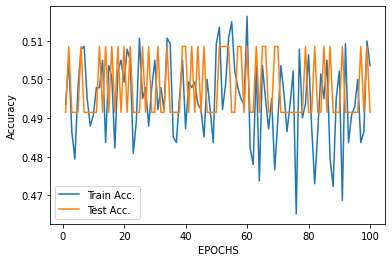

In [ ]:
print(f"Final Train Acc = {data['binary_accuracy'][-1]}")
print(f"Final Test Acc = {data['val_binary_accuracy'][-1]}")
plot([data['binary_accuracy'], data['val_binary_accuracy']], ['Train Acc.', 'Test Acc.'], x_label='EPOCHS', y_label='Accuracy')

Final Train Loss = 0.7736141085624695
Final Test Loss = 0.767953097820282


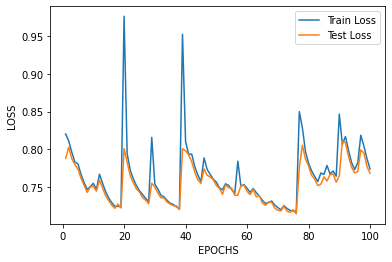

In [ ]:
print(f"Final Train Loss = {data['loss'][-1]}")
print(f"Final Test Loss = {data['val_loss'][-1]}")
plot([data['loss'], data['val_loss']], ['Train Loss', 'Test Loss'], x_label='EPOCHS', y_label='LOSS')

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


def plot(args, labels, x_label: str = None, y_label: str = None, tag: str = None, path: str = '.', show=True):
    for arg, label in zip(args, labels):
        epochs = [i+1 for i in range(len(arg))]
        plt.plot(epochs, arg, label=label)

    if y_label:
        plt.ylabel(y_label)
    if x_label:
        plt.xlabel(x_label)

    if tag:
        plt.title(tag)

    plt.legend()
    if path:
        plt.savefig(path)
    if show:
      plt.show()
    else:
      plt.clf()

In [ ]:
from keras.layers import  Input, Embedding, Dense, LSTM
from keras.models import Model
import keras
import keras.utils

In [ ]:
model_n = keras.models.Sequential()

model_n.add(keras.layers.LSTM(units=32, batch_input_shape=(32, 41, 4), return_sequences=True))
model_n.add(keras.layers.LSTM(units=64, return_sequences=False))
model_n.add(Dense(units=1, activation='sigmoid'))
model_n.summary()



Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (32, 41, 32)              4736      
_________________________________________________________________
lstm_23 (LSTM)               (32, 64)                  24832     
_________________________________________________________________
dense_30 (Dense)             (32, 1)                   65        
Total params: 29,633
Trainable params: 29,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_n.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [ ]:
hist_ = model_n.fit(train_x, train_y,
          batch_size=32, epochs=100,
          validation_data=(test_x, test_y))

Epoch 1/100
44/44 [==============================] - 1s 32ms/step - loss: 0.9721 - accuracy: 0.5028 - val_loss: 0.6897 - val_accuracy: 0.5142
Epoch 2/100
44/44 [==============================] - 1s 31ms/step - loss: 0.7052 - accuracy: 0.4794 - val_loss: 0.6915 - val_accuracy: 0.4972
Epoch 3/100
44/44 [==============================] - 1s 31ms/step - loss: 0.7239 - accuracy: 0.4964 - val_loss: 0.7172 - val_accuracy: 0.5199
Epoch 4/100
44/44 [==============================] - 1s 31ms/step - loss: 0.7176 - accuracy: 0.4773 - val_loss: 0.7034 - val_accuracy: 0.4886
Epoch 5/100
44/44 [==============================] - 1s 32ms/step - loss: 0.6988 - accuracy: 0.5241 - val_loss: 0.7008 - val_accuracy: 0.4744
Epoch 6/100
44/44 [==============================] - 1s 32ms/step - loss: 0.6963 - accuracy: 0.5320 - val_loss: 0.7029 - val_accuracy: 0.4801
Epoch 7/100
44/44 [==============================] - 1s 32ms/step - loss: 0.6920 - accuracy: 0.5241 - val_loss: 0.6992 - val_accuracy: 0.5284
Epoch 

In [ ]:
print(hist_.history.keys())
data_n = hist_.history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Final Train Acc = 0.9630681872367859
Final Test Acc = 0.6136363744735718


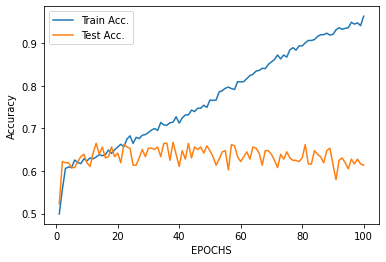

In [ ]:
print(f"Final Train Acc = {data_n['accuracy'][-1]}")
print(f"Final Test Acc = {data_n['val_accuracy'][-1]}")
plot([data_n['accuracy'], data_n['val_accuracy']], ['Train Acc.', 'Test Acc.'], x_label='EPOCHS', y_label='Accuracy')

Final Train Loss = 0.7736141085624695
Final Test Loss = 0.767953097820282


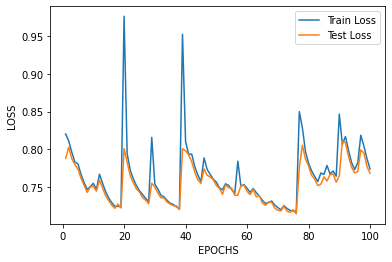

In [ ]:
print(f"Final Train Loss = {data['loss'][-1]}")
print(f"Final Test Loss = {data['val_loss'][-1]}")
plot([data['loss'], data['val_loss']], ['Train Loss', 'Test Loss'], x_label='EPOCHS', y_label='LOSS')